#Background

Jira is a tool that tracks items of work in an ‘issue’. These issues move from ‘to-do’ to ‘doing' and ‘done’. You have been approached by the Head of Product who has an important Board meeting soon. The Board is interested in a new feature that we are calling ‘Team Tracking' that we shipped to customers at the start of the year. This feature allows our customers to track a range of activities that their teammates do in  Jira, such as how many ‘issues’ were ‘closed’ by their team in a given period. These are presented to the customer in a dashboard that they can access from within  Jira itself. The Head of Product wants to show the board how many people, on average, view these new dashboards daily.




#Objective

**Question 1**
We want to understand what is the average number of times our users view the dashboard feature per day. In our data, a person viewing a dashboard is recognised by a view.dashboard event.
Create a line chart that plots the mean daily dashboard views for the period. Include a way to quickly assess variation in the daily means

**Question 2**
Compare the proportion of users who viewed the new Dashboard feature (view.dashboard) between the period 2022-01-01 -> 2022-01-07 (inclusive) and 2022-01-25 -> 2022-01-31 (inclusive).
Are the proportions different from each other? What is the margin of error?



#Approach

**Data Loading and Preprocessing**:

* Data Loading: Load the dataset containing user actions within Jira.
* Data Cleaning: Preprocess the dataset by converting datetime columns, handling missing values, and filtering for events related to viewing the 'Team Tracking' dashboard feature ('view.dashboard').

**Analysis**:

Question 1: Average Daily Dashboard Views:


*   **Data Aggregation**: Group data by date and user to obtain daily views per user.
*   **Outlier Detection**: Assess outliers in daily views and consider mean, median, and rolling mean views for robust analysis.
*   **Visualization**: Create line charts to visualize trends in daily dashboard views, including mean, median, rolling mean, total views, and total users.
*   **Statistical Analysis**: Analyze variation in daily means using standard deviations and z-scores.

Question 2: Comparison of User Proportions:

*   **Time Period Definition**: Define two distinct time periods for comparison.
*   **Data Subset**: Extract data for the defined time periods for comparison.
*   **Calculate Proportions**: Determine the proportions of users who viewed the dashboard feature during each period relative to the total unique users.
*   **Statistical Test**: Perform a proportions Z-test to assess the significance of differences in user engagement between the two periods.
*   **Margin of Error**: Calculate the margin of error for the proportions.





# Data Loading, Cleaning and Manipulation

###Importing Libraries

In [182]:
# data manipulation libraries
import numpy as np
import pandas as pd

# data vizualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# statistical libraries
from statsmodels.stats.proportion import proportions_ztest

###Loading the Dataset

In [183]:
# Load the dataset
df = pd.read_csv('atlassian_take_home_data.csv')

# Display the first few rows of the dataset
df.head()

,user,action,date_time
0,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 07:44:06
1,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 09:38:12
2,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 07:52:43
3,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 09:07:54
4,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 07:29:59


###Dataset Overview

In [184]:
# Display the shape of the dataset (number of rows and columns)
print(f"Dataset Shape: {df.shape}")

# Calculate and display the number of unique users
unique_users = df['user'].nunique()
print(f"Unique Users: {unique_users}")

Dataset Shape: (235297, 3)
Unique Users: 1000


In [185]:
# Finding the distribution of user action
df['action'].value_counts()

edit.issue        97902
move.issue        64980
view.dashboard    52889
view.issue        19526
Name: action, dtype: int64

In [186]:
# Finding the % distribution of user action
df['action'].value_counts(normalize=True)

edit.issue        0.416078
move.issue        0.276162
view.dashboard    0.224775
view.issue        0.082984
Name: action, dtype: float64

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235297 entries, 0 to 235296
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user       235297 non-null  object
 1   action     235297 non-null  object
 2   date_time  230653 non-null  object
dtypes: object(3)
memory usage: 5.4+ MB


**"date_time" column have some missing value. We have to treat the missing value**

###Filtering for "view.dashboard" Events
As the case study focuses on analyzing **"view.dashboard" events**, filter the dataset accordingly.

In [188]:
# Filter the dataset for 'view.dashboard' events
df_dashboard = df[df['action'] == 'view.dashboard']

# Display the first few rows of the filtered dataset
df_dashboard.head()

,user,action,date_time
0,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 07:44:06
1,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 09:38:12
2,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 07:52:43
3,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 09:07:54
4,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 07:29:59


###Filtered Dataset Overview

In [189]:
df_dashboard.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52889 entries, 0 to 52888
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user       52889 non-null  object
 1   action     52889 non-null  object
 2   date_time  51836 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


In [190]:
# Finding the number of rows and columns in Dataframe
df_dashboard.shape

(52889, 3)

In [191]:
# Finding the number of null values in each column
df_dashboard.isnull().sum()

user            0
action          0
date_time    1053
dtype: int64

In [192]:
df_dashboard.isnull().sum()*100/len(df_dashboard)

user         0.000000
action       0.000000
date_time    1.990962
dtype: float64

**~2%** of the records in date_time column are null. We have to treat the missing value

In [193]:
# Looking at count of user records to understand the usage per user
df_dashboard.groupby('user').size().reset_index(name='count').sort_values(by='count', ascending=False).reset_index(drop=True)

,user,count
0,53c1f1a28843e83e70244bea968770,139
1,cd7cabddef85972960f423590775f1,129
2,042c775a185d502cf3fdb75686fc20,126
3,99ab99d684fa4cf4b6b8547fa6704b,125
4,db1bf88c82459b70c1ae0de90ce763,124
...,...,...
995,22b4db1db844ca669ceed4c33f5e04,8
996,fc41f940d424033cfc231947424c2e,7
997,e80646ba0e90b25e581dcb4e56c8f5,7
998,ed085cf9bff1b6e10390534c011ba3,7


Usage of feature seems to have a skewed distribution suggesting some users are power users and use feature more compared to other users

### Data Cleaning and Data Manipulation

In this step, we will create new columns, clean the data for missing values and outlier removal

#### Transforming the datatime column to Date column

In [194]:
# Convert 'date_time' to datetime format explicitly in df_dashboard
df_dashboard['date_time'] = pd.to_datetime(df_dashboard['date_time'], errors='coerce')  # 'coerce' will convert problematic values to NaT

# After conversion, create a new column 'date' with just the date part
df_dashboard['date'] = pd.to_datetime(df_dashboard['date_time'].dt.date)

# Get the day of the week name
df_dashboard['day_of_week'] = df_dashboard['date_time'].dt.day_name()

# Display the first few rows to verify
df_dashboard.head()

<ipython-input-194-79a1e1233baa>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-194-79a1e1233baa>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-194-79a1e1233baa>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,user,action,date_time,date,day_of_week
0,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 07:44:06,2022-01-01,Saturday
1,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 09:38:12,2022-01-01,Saturday
2,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 07:52:43,2022-01-01,Saturday
3,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 09:07:54,2022-01-01,Saturday
4,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 07:29:59,2022-01-01,Saturday


#### Treating the missing value

##### Counting the number of missing records

In [195]:
df_dashboard.isnull().sum()

user              0
action            0
date_time      1053
date           1053
day_of_week    1053
dtype: int64

##### Checking if missing records belong to a specific user/user group

In [196]:
# Identify rows with missing values in df_dashboard
df_with_missing = df_dashboard[df_dashboard['date_time'].isnull()]

In [197]:
df_with_missing['user'].nunique()*100/df_dashboard['user'].nunique()

63.3

Roughly 63.3% of the users have at least one missing value. Hence, the **missing values are not concentrated** to specific user sets

##### Checking if missing valued belong to a specific date

In [198]:
# Count records per date
date_counts = df_dashboard.groupby('date').size().reset_index(name='count')

# Create an interactive line plot
fig = px.line(date_counts, x='date', y='count', title='Count of Records by Date', markers=True)

# Show the plot
fig.show()

**The number of records look relatively low for Jan 8th**

In [199]:
# Filter for records on Saturdays
saturdays_df = df_dashboard[df_dashboard['day_of_week'] == 'Saturday']

# Count records for each Saturday
saturday_counts = saturdays_df.groupby('date').size().reset_index(name='count')

# Sort the counts by date
saturday_counts = saturday_counts.sort_values('date')

# Display the results
print(saturday_counts)

        date  count
0 2022-01-01   1032
1 2022-01-08     62
2 2022-01-15   1277
3 2022-01-22    716
4 2022-01-29   1670


**Further analysis revealed a significantly lower record count for January 8th compared to other Saturdays, suggesting a potential anomaly in data logging on that specific date.**

In [200]:
df_week_day = df_dashboard[['date','day_of_week']].value_counts().sort_index().reset_index(name='daily_count')

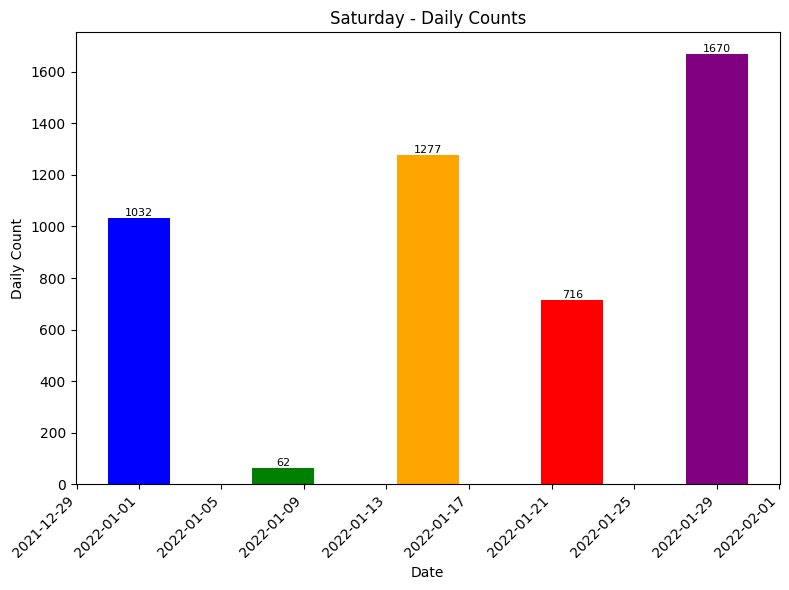

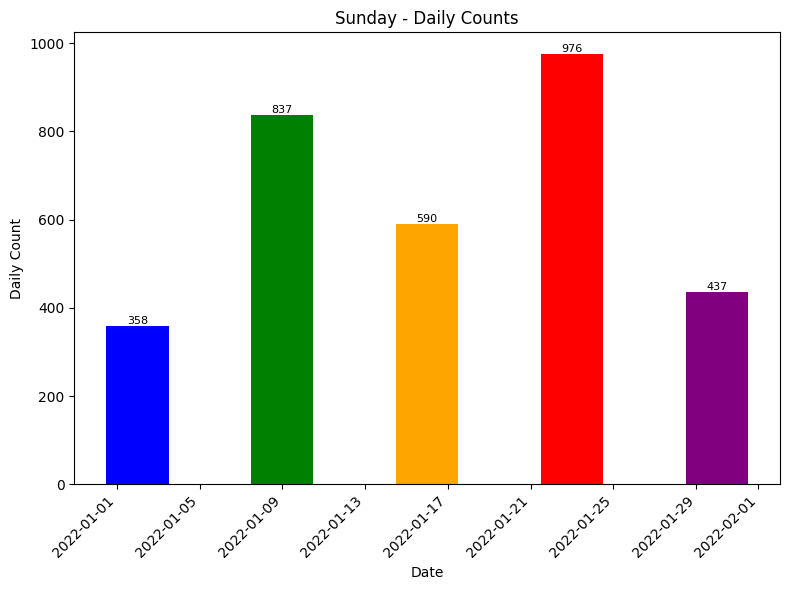

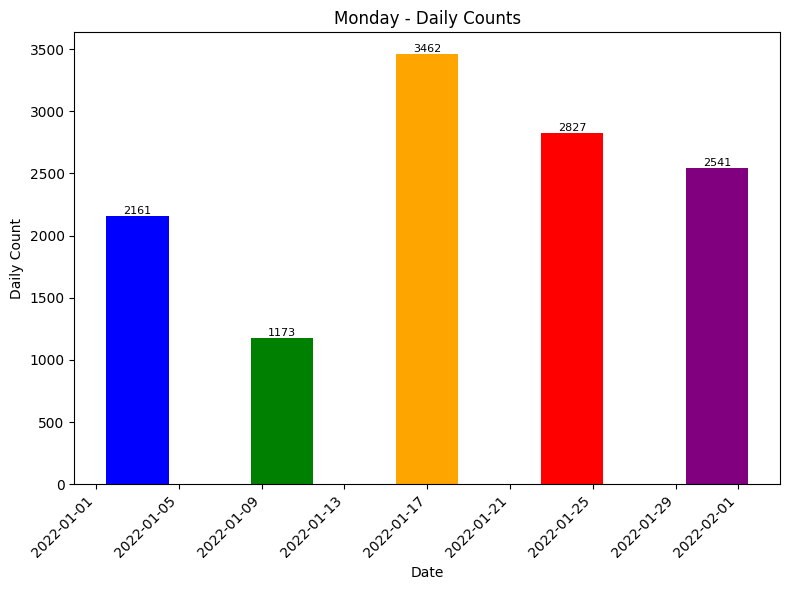

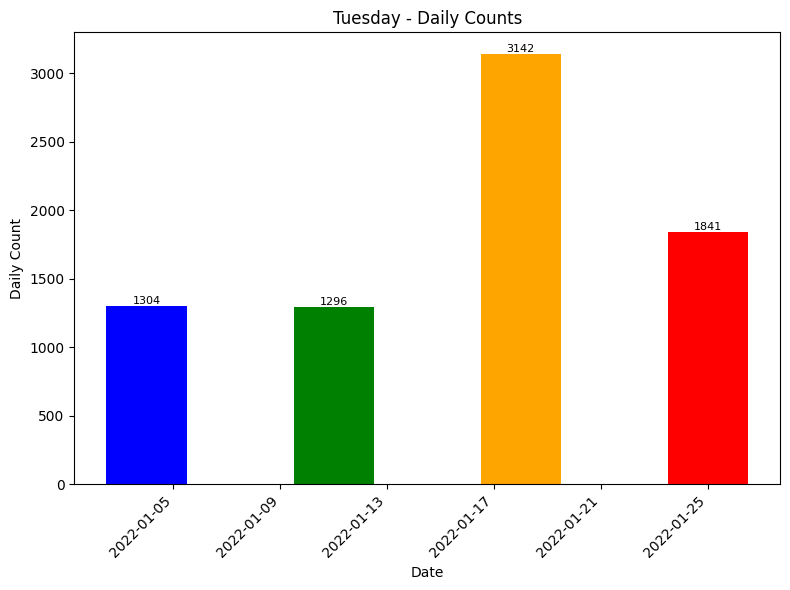

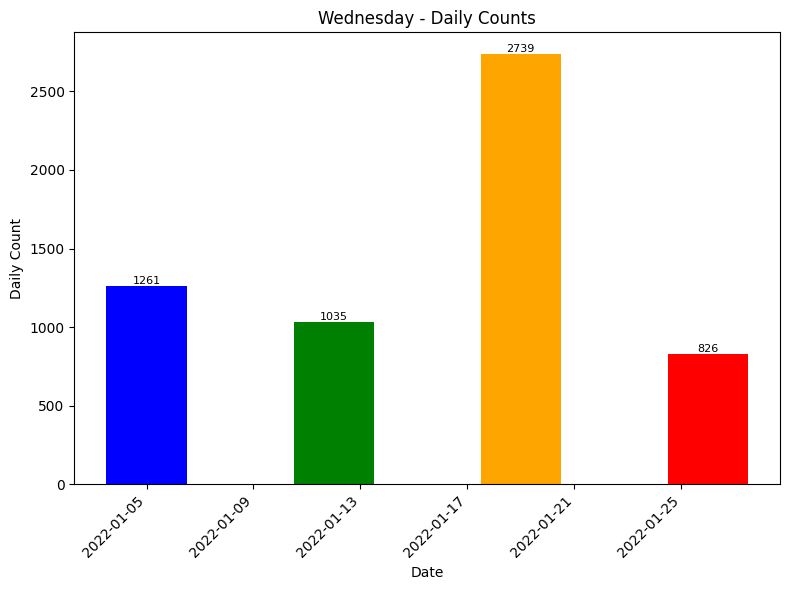

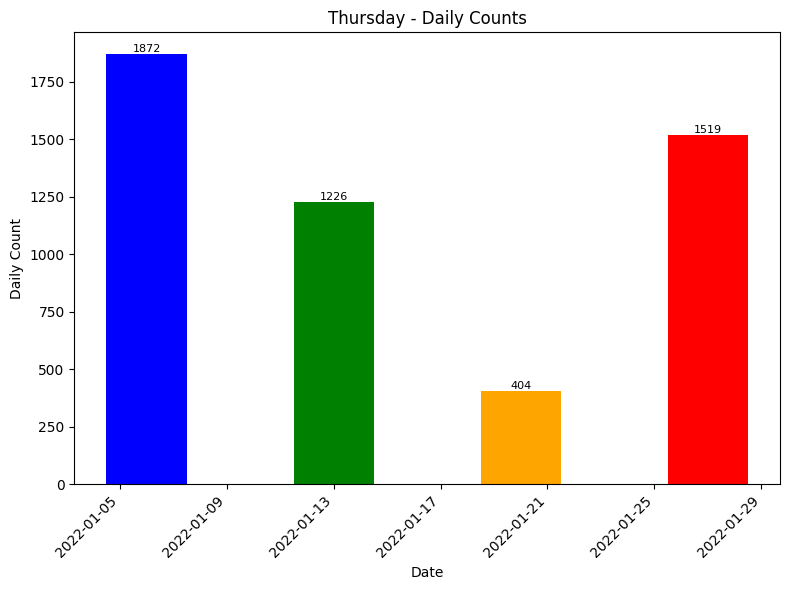

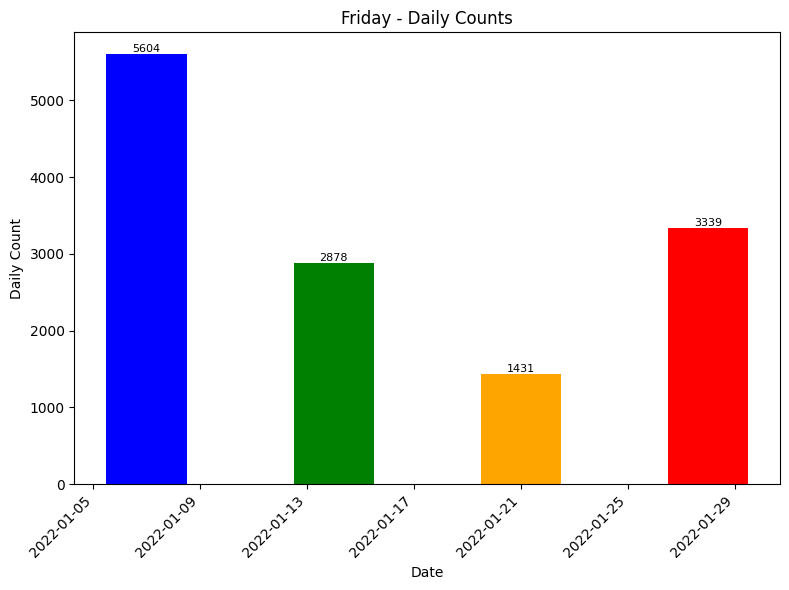

In [201]:
# Analyzing the record count distribution across various dates for same weekday

# Get unique days of the week
days_of_week = df_week_day['day_of_week'].unique()

# Define colors for each day
colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown', 'pink']

# Plotting for each day of the week
for day in days_of_week:
    # Filter data for the current day
    day_data = df_week_day[df_week_day['day_of_week'] == day]

    # Plot
    plt.figure(figsize=(8, 6))  # Adjust figure size
    bar_width = 3 # Adjust bar width
    for i, (date, count) in enumerate(zip(day_data['date'], day_data['daily_count'])):
        plt.bar(date, count, width=bar_width, color=colors[i % len(colors)])  # Cycle through colors

        # Adding data labels
        plt.text(date, count, str(count), ha='center', va='bottom', fontsize=8)  # Adjust fontsize as needed

    plt.xlabel('Date')
    plt.ylabel('Daily Count')
    plt.title(f'{day} - Daily Counts')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()


The above chart further strengthens our observation that compared to all other data points 8th January seem anomalous. However, we have seen huge variance in daily record counts across different dates for same week day

**Hence, we cannot make an assumption that all missing values belong to 8th Jan. We have to understand the root cause.**

**Hence, we will drop the missing value rows for the time being. However, the ideal approach would have been understanding the low record count for 8th Jan and impute the missing date**

##### Dropping the missing values from the DataFrame

In [202]:
df_db_clean = df_dashboard.dropna()

In [203]:
df_db_clean.head()

,user,action,date_time,date,day_of_week
0,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 07:44:06,2022-01-01,Saturday
1,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 09:38:12,2022-01-01,Saturday
2,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 07:52:43,2022-01-01,Saturday
3,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 09:07:54,2022-01-01,Saturday
4,82a5b016209b5f543419529bdadd08,view.dashboard,2022-01-01 07:29:59,2022-01-01,Saturday


# Question 1

We want to understand what is the average number of times our users view the dashboard feature per day.

Create a line chart that plots the mean daily dashboard views for the period. Include a way to quickly assess variation in the daily means

## Approach for solution:

We will break down this problem into following parts:


1. Define the metric:
Average number of time user view the dashboard feature = **Total daily views/Total daily users**
2.  Create a dataframe for each day and user along with the count of views
3.   Check if the distribution is skewed. If skewed distribution, we will look into median as well as do the outlier removal for calculating the mean
4. For assessing variation, we will look at standard deviation



In [204]:
# Creating a dataframe for each day and user with view count
df_grouped = (
    df_db_clean.groupby(["date", 'day_of_week', "user"])["action"]
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={'view.dashboard': 'daily_views'})
)
df_grouped.head()

action,date,day_of_week,user,daily_views
0,2022-01-01,Saturday,05027c00dcada81bc2f38080476e24,5
1,2022-01-01,Saturday,05a5349061ea1720ac39c4a44b16bf,14
2,2022-01-01,Saturday,08378d6073daabb4e8bb1b6b0a3332,9
3,2022-01-01,Saturday,0be61bed14ae58113b002d51d79f03,16
4,2022-01-01,Saturday,0fcd6672912fc32f7136347e4b8e8b,4


In [205]:
# Statistics for aggregated data
df_grouped[df_grouped["date"] == "2022-01-1"].describe()

action,daily_views
count,116.000000
mean,8.896552
std,5.786610
min,1.000000
25%,4.000000
50%,8.500000
75%,13.000000
max,24.000000


### Calculating the mean daily dashboard views for the period

As mentioned earlier, we will calculate the mean daily dashboard as **Total Number of Views per day/ Total users per day**

However, there is a possibility that there are power users that can skew the mean. Hence, we will check the data for outliers

In [206]:
# Aggregation
daily_stats_agg = df_grouped.groupby(['date', 'day_of_week']).agg(
    total_views=('daily_views', 'sum'),
    mean_views=('daily_views', 'mean'),
    median_views=('daily_views', 'median'),
    std_dev_views=('daily_views', 'std'),
    q1_views=('daily_views', lambda x: np.percentile(x, 25)),
    q3_views=('daily_views', lambda x: np.percentile(x, 75)),
    max_views=('daily_views', 'max'),
    min_views=('daily_views', 'min'),
    daily_user_count=('user', 'nunique')  # Count unique users per day
).reset_index()

# Calculate the Interquartile Range (IQR)
daily_stats_agg['iqr'] = daily_stats_agg['q3_views'] - daily_stats_agg['q1_views']

# Identify outliers using the IQR rule
daily_stats_agg['is_upper_outlier'] = daily_stats_agg['max_views'] > (daily_stats_agg['q3_views'] + 1.5 * daily_stats_agg['iqr'])
daily_stats_agg['is_lower_outlier'] = daily_stats_agg['min_views'] < (daily_stats_agg['q1_views'] - 1.5 * daily_stats_agg['iqr'])

daily_stats_agg.head()


,date,day_of_week,total_views,mean_views,median_views,std_dev_views,q1_views,q3_views,max_views,min_views,daily_user_count,iqr,is_upper_outlier,is_lower_outlier
0,2022-01-01,Saturday,1032,8.896552,8.5,5.786610,4.00,13.0,24,1,116,9.00,False,False
1,2022-01-02,Sunday,358,8.523810,7.5,6.208720,4.00,12.0,32,1,42,8.00,True,False
2,2022-01-03,Monday,2161,7.773381,7.0,5.011439,4.00,11.0,25,1,278,7.00,True,False
3,2022-01-04,Tuesday,1304,8.000000,7.0,5.029542,4.00,11.5,22,1,163,7.50,False,False
4,2022-01-05,Wednesday,1261,8.756944,9.0,5.549833,4.75,12.0,26,1,144,7.25,True,False


Due to the presence of outliers in daily views for some days, the **median is a more robust measure of central tendency** compared to the mean when analyzing the average number of views per user per day.

### Plotting the line chart for average daily dashboard view

We will create 6 charts


1.   Line chart for daily mean views with error bars
2.   Line chart for daily median views
3.   Line chart for 7-day rolling mean views
4.   Line chart for 7-day rolling median views
3.   Line chart for daily total views
3.   Line chart for daily total users




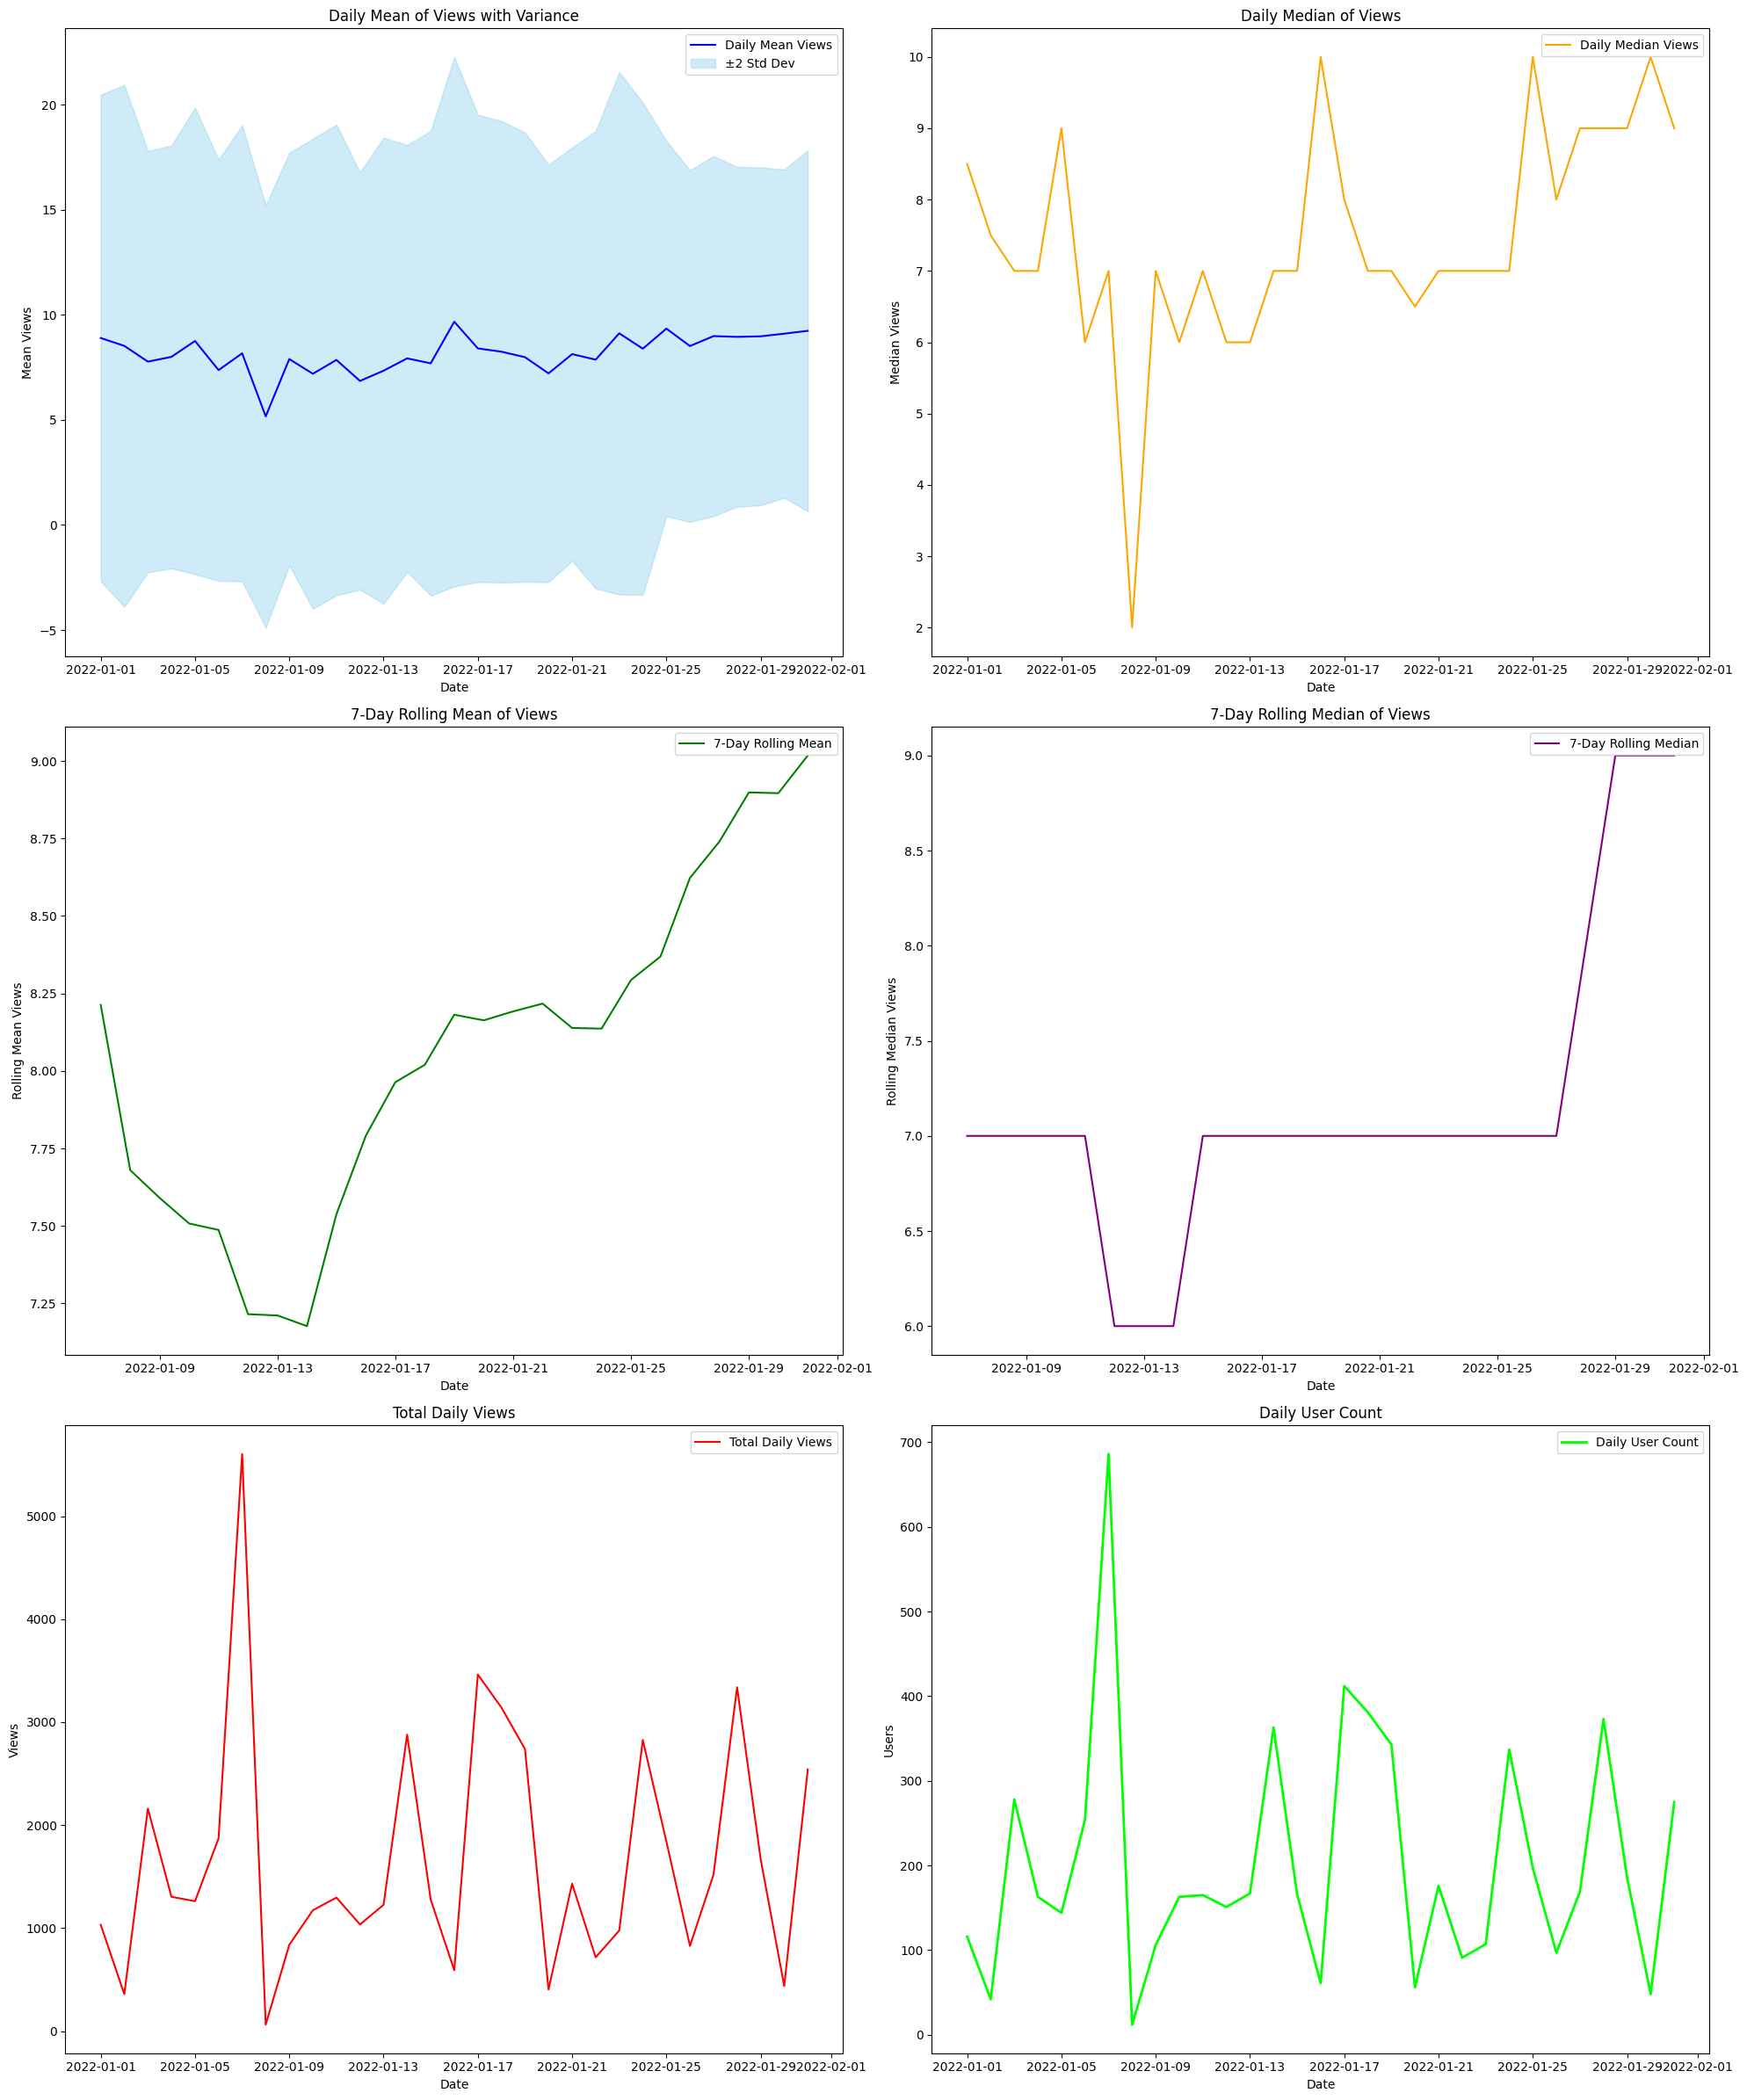

In [207]:
# Creating a figure with six subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 24))  # Adjusting the layout to fit 6 plots

# Plot Daily Mean Views with 2 Standard Deviations Shaded Area
axes[0, 0].plot(daily_stats_agg['date'], daily_stats_agg['mean_views'], label='Daily Mean Views', color='blue')
axes[0, 0].fill_between(daily_stats_agg['date'],
                        daily_stats_agg['mean_views'] + 2 * daily_stats_agg['std_dev_views'],
                        daily_stats_agg['mean_views'] - 2 * daily_stats_agg['std_dev_views'],
                        color='skyblue', alpha=0.4, label='±2 Std Dev')
axes[0, 0].set_title('Daily Mean of Views with Variance')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Mean Views')
axes[0, 0].legend()

# Plot Daily Median Views
axes[0, 1].plot(daily_stats_agg['date'], daily_stats_agg['median_views'], label='Daily Median Views', color='orange')
axes[0, 1].set_title('Daily Median of Views')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Median Views')
axes[0, 1].legend()

# Plot 7-Day Rolling Mean Views
axes[1, 0].plot(daily_stats_agg['date'], daily_stats_agg['mean_views'].rolling(window=7).mean(), label='7-Day Rolling Mean', color='green')
axes[1, 0].set_title('7-Day Rolling Mean of Views')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Rolling Mean Views')
axes[1, 0].legend()

# Plot 7-Day Rolling Median Views
axes[1, 1].plot(daily_stats_agg['date'], daily_stats_agg['median_views'].rolling(window=7).median(), label='7-Day Rolling Median', color='purple')
axes[1, 1].set_title('7-Day Rolling Median of Views')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Rolling Median Views')
axes[1, 1].legend()

# Plot Total Daily Views
axes[2, 0].plot(daily_stats_agg['date'], daily_stats_agg['total_views'], label='Total Daily Views', color='red')
axes[2, 0].set_title('Total Daily Views')
axes[2, 0].set_xlabel('Date')
axes[2, 0].set_ylabel('Views')
axes[2, 0].legend()

# Plot Total Daily User Count
axes[2, 1].plot(daily_stats_agg['date'], daily_stats_agg['daily_user_count'], label='Daily User Count', color='lime', linewidth=2)
axes[2, 1].set_title('Daily User Count')
axes[2, 1].set_xlabel('Date')
axes[2, 1].set_ylabel('Users')
axes[2, 1].legend()

# Adjust layout for a clean look
plt.tight_layout()

# Display the plot
plt.show()


### Analyzing Daily View and Daily Users Trends by Weekday

In [208]:
# Ensure 'weekday_order' is defined correctly to sort days of the week
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group data by 'day_of_week' and aggregate necessary metrics
weekday_stats = df_grouped.groupby('day_of_week').agg(
    total_views=('daily_views', 'sum'),                 # Total views per weekday
    total_users=('user', 'nunique'),                    # Unique users per weekday
    number_of_dates=('date', 'nunique')                  # Unique dates per weekday
).reindex(weekday_order).reset_index()                  # Ensure proper weekday ordering

# Calculate the average views per unique user per weekday
weekday_stats['avg_views_per_user'] = weekday_stats['total_views'] / weekday_stats['total_users']

# Calculate the average users per date per weekday
weekday_stats['users_per_date'] = weekday_stats['total_users'] / weekday_stats['number_of_dates']



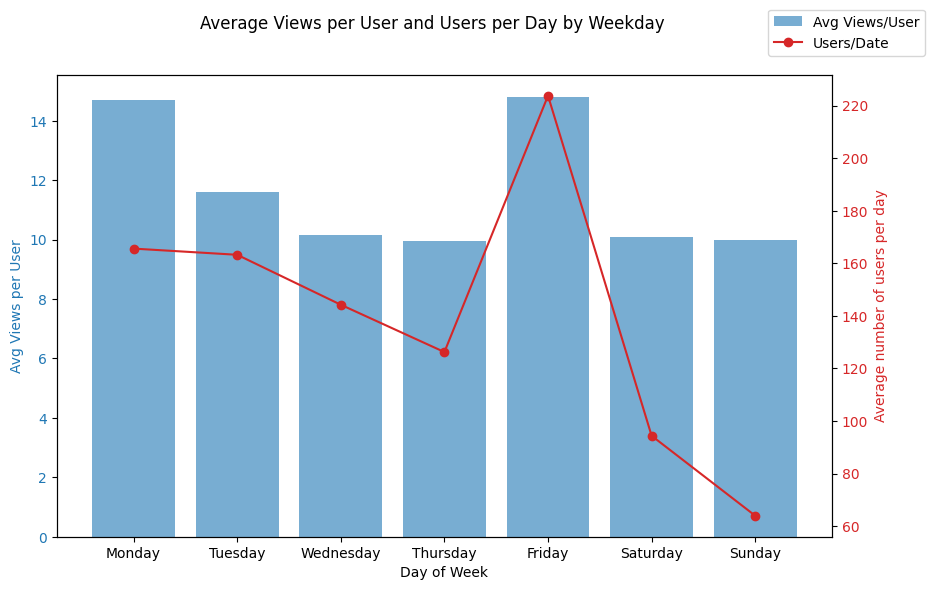

In [209]:
# Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'tab:blue'
color2 = 'tab:red'

# Bar chart for average views per user
ax1.bar(weekday_stats['day_of_week'], weekday_stats['avg_views_per_user'], color=color1, alpha=0.6, label='Avg Views/User')
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Avg Views per User', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second axis for users per date
ax2 = ax1.twinx()
ax2.plot(weekday_stats['day_of_week'], weekday_stats['users_per_date'], color=color2, marker='o', label='Users/Date')
ax2.set_ylabel('Average number of users per day', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Title and legend
fig.suptitle('Average Views per User and Users per Day by Weekday')
fig.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.show()


### Assessing Variation in daily means


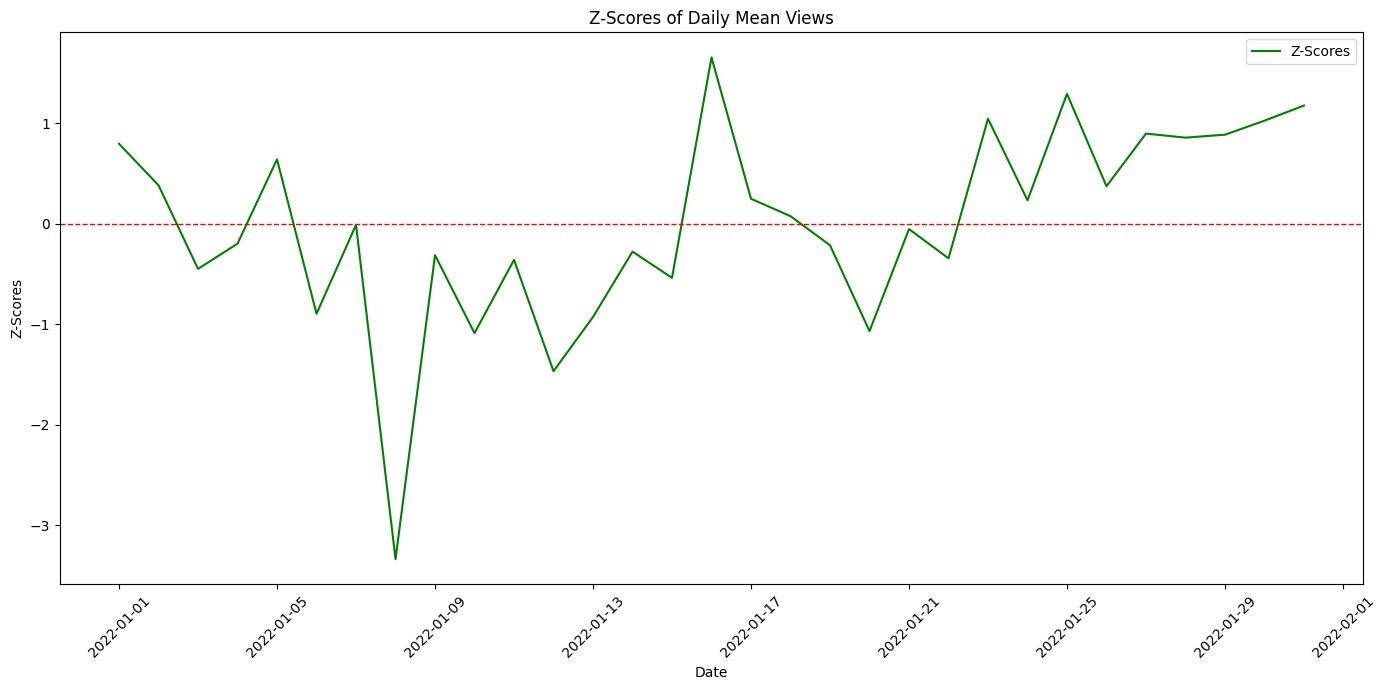

In [210]:
# Calculate z-scores for the daily mean views
daily_mean_views_mean = daily_stats_agg['mean_views'].mean()
daily_mean_views_std = daily_stats_agg['mean_views'].std()
daily_stats_agg['z_score'] = (daily_stats_agg['mean_views'] - daily_mean_views_mean) / daily_mean_views_std

# Plot z-scores over time
plt.figure(figsize=(14, 7))
plt.plot(daily_stats_agg['date'], daily_stats_agg['z_score'], label='Z-Scores', color='green')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add a horizontal line at z=0 for reference
plt.title('Z-Scores of Daily Mean Views')
plt.xlabel('Date')
plt.ylabel('Z-Scores')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Key Observations


*   **Daily Engagement Variability**: The analysis demonstrates significant day-to-day variability in user engagement, with certain days showing notably higher or lower dashboard views. This variability suggests the influence of external factors or internal initiatives affecting user interaction.
*   **Median vs. Mean Views**: The median views per day offer a stable engagement metric, suggesting a consistent core user base. In contrast, mean views are more affected by outliers, indicating sporadic spikes in usage that may correspond to specific events or releases.


*   **Weekly Engagement Patterns**: Aggregated data by day of the week uncovers distinct patterns, with certain days experiencing higher engagement. This pattern can inform the scheduling of updates, maintenance, and communications to align with peak and off-peak user activity periods.
List item
*   **User Distribution and Engagement**: The analysis of average views per user juxtaposed with users per date provides a nuanced understanding of how engagement depth (intensity of use) and breadth (number of users) vary across the week.





# Question-2

Compare the proportion of users who viewed the new Dashboard feature (view.dashboard) between the period 2022-01-01 -> 2022-01-07 (inclusive) and 2022-01-25 -> 2022-01-31 (inclusive).
Are the proportions different from each other? What is the margin of error?


## Approach for solution:


*   **Defining Time Periods**: The first step is to define the two time periods for comparison. In this case, we have specified two periods: January 1st to January 7th and January 25th to January 31st.
*   **Data Subsetting**: Next, we subset the dataset to extract data corresponding to the defined time periods. This ensures that we are working with data relevant to the analysis.
*   **Calculating Unique Users**: We calculate the number of unique users who viewed the dashboard feature during each time period. This is essential for comparing the proportions of users across the two periods.
*   **Calculating Proportions**: We calculate the proportion of users who viewed the dashboard feature relative to the total number of unique users for each time period. This allows us to understand the relative engagement with the feature during each period.
*   **Performing Proportions Z-test**: To determine whether the difference in proportions between the two periods is statistically significant, we perform a proportions Z-test. This test helps us evaluate whether any observed differences are likely due to chance or if they represent true differences in user engagement.
*   **Calculating Margin of Error**: Additionally, we calculate the margin of error for the proportions to understand the range within which the true population proportions are likely to lie.
















### Data Preparation for Proportions Test

In [211]:
# Define the two time periods
period_1_start = '2022-01-01'
period_1_end = '2022-01-07'
period_2_start = '2022-01-25'
period_2_end = '2022-01-31'

In [212]:
# Subset data for the two time periods
subset_1 = df_grouped[(df_grouped['date'] >= period_1_start) & (df_grouped['date'] <= period_1_end)]
subset_2 = df_grouped[(df_grouped['date'] >= period_2_start) & (df_grouped['date'] <= period_2_end)]

In [213]:
# Calculate unique users for each period
p1 = subset_1['user'].nunique()
p2 = subset_2['user'].nunique()

# Total unique users
n1 = df_grouped['user'].nunique()
n2 = df_grouped['user'].nunique()

# Print the number of unique users for each period and the total unique users
print("Unique users in period 1:", p1)
print("Unique users in period 2:", p2)
print("Total unique users:", n1)


Unique users in period 1: 896
Unique users in period 2: 788
Total unique users: 1000


In [214]:
# Calculate proportions of users viewing the dashboard
prop_1 = p1 / n1
prop_2 = p2 / n2

# Print the proportions
print("Proportion of users viewing the dashboard in period 1:", prop_1)
print("Proportion of users viewing the dashboard in period 2:", prop_2)

Proportion of users viewing the dashboard in period 1: 0.896
Proportion of users viewing the dashboard in period 2: 0.788


### Conducting Proportions Test

In [215]:
# Perform proportions z-test
stat, pval = proportions_ztest([p1, p2], [n1, n2])

# Print the output
print("Z-test statistic:", stat)
print("P-value:", pval)


Z-test statistic: 6.621008850680366
P-value: 3.56755607731302e-11


In [216]:
# Calculate margin of error for proportions
margin_of_error = 1.96 * ((prop_1 * (1 - prop_1) / n1) + (prop_2 * (1 - prop_2) / n2)) ** 0.5

# Print the margin of error
print("Margin of error:", margin_of_error)



Margin of error: 0.031618633493558826


In [217]:
# Calculate confidence intervals for proportions
conf_interval_1 = (prop_1 - margin_of_error, prop_1 + margin_of_error)
conf_interval_2 = (prop_2 - margin_of_error, prop_2 + margin_of_error)

# Print confidence intervals
print("Confidence interval for period 1:", conf_interval_1)
print("Confidence interval for period 2:", conf_interval_2)

Confidence interval for period 1: (0.8643813665064412, 0.9276186334935589)
Confidence interval for period 2: (0.7563813665064412, 0.8196186334935589)


### Statistics from the Proportions Test

In [218]:
# Print results
print("\nZ-test statistic:", stat)
print("P-value:", pval)
print("Margin of error:", margin_of_error)

# Check if the difference is statistically significant
alpha = 0.05
if pval < alpha:
    print("The difference in proportions is statistically significant (reject null hypothesis).")
else:
    print("The difference in proportions is not statistically significant (fail to reject null hypothesis).")



Z-test statistic: 6.621008850680366
P-value: 3.56755607731302e-11
Margin of error: 0.031618633493558826
The difference in proportions is statistically significant (reject null hypothesis).


### Key Observations:

*  Z-test Statistic: The Z-test statistic value is 6.62, indicating a substantial difference in proportions between the two time periods.

*  P-value: The extremely low p-value (3.57e-11) suggests strong evidence against the null hypothesis, indicating that the difference in proportions is highly unlikely to be due to chance.

*  Margin of Error: The margin of error is calculated to be approximately 0.032, indicating the range within which the true population proportions are likely to fall.

*  Statistical Significance: With a p-value significantly lower than the significance level of 0.05, we reject the null hypothesis and conclude that the difference in proportions of users viewing the dashboard feature between the two periods is statistically significant.

Overall, these findings suggest that there is a substantial difference in user engagement with the dashboard feature between the two time periods, with the latter period showing significantly higher user engagement.